In [1]:
import os
import cv2
import random
import numpy as np

In [31]:
LEAF_DATASET_DIR = "urban_street0_25"
LEAF_IMAGES_DIR = os.path.join(LEAF_DATASET_DIR, "images")
LEAF_MASKS_DIR = os.path.join(LEAF_DATASET_DIR, "leaf_instances")
BACKGROUND_IMAGES_DIR = "street_view"
DATASET_DIR = "synthetic"
DATA_DIR = "synthetic_leaf_instances"
DATA_SUBDIR = os.path.join(DATASET_DIR, DATA_SUBDIR)
TRAIN_IMAGES_DIR = "train/images"
TRAIN_IMAGES_SUBDIR = os.path.join(DATA_SUBDIR, TRAIN_IMAGES_DIR)
TRAIN_LABELS_DIR = "train/labels"
TRAIN_LABELS_SUBDIR = os.path.join(DATA_SUBDIR, TRAIN_LABELS_DIR)
VAL_IMAGES_DIR = "val/images"
VAL_IMAGES_SUBDIR = os.path.join(DATA_SUBDIR, VAL_IMAGES_DIR)
VAL_LABELS_DIR = "val/labels"
VAL_LABELS_SUBDIR = os.path.join(DATA_SUBDIR, VAL_LABELS_DIR)
DATASET_SPLIT = 0.8

In [6]:
dataset = {
    "names": {
        0: "leaf"
    },
    "path": DATA_DIR,
    "train": TRAIN_IMAGES_DIR,
    "val": VAL_IMAGES_DIR
}

In [7]:
import yaml

# Define the output file path
output_file_path = os.path.join(DATASET_DIR, "dataset.yaml")

# Create the necessary directories if they don't exist
os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

# Dump the dataset dictionary to a YAML file
with open(output_file_path, 'w') as file:
    yaml.dump(dataset, file, default_flow_style=False)

print(f"Dataset configuration saved to {output_file_path}")

Dataset configuration saved to synthetic/dataset.yaml


In [8]:
def transform_image(image, mask, angle, scale, tx, ty):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    # Rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    # Translation matrix
    rotation_matrix[0, 2] += tx
    rotation_matrix[1, 2] += ty

    # Apply the transformation
    transformed_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    transformed_mask = cv2.warpAffine(mask, rotation_matrix, (width, height))
    return transformed_image, transformed_mask

In [9]:
def apply_mask(image, mask):
    image = cv2.bitwise_and(image, image, mask=mask)
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return np.array([]), np.array([])
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    image = image[y_min:y_max+1, x_min:x_max+1]
    mask = mask[y_min:y_max+1, x_min:x_max+1]
    return image, mask

In [10]:
def create_segmentation_mask(image, mask, value):
    segmented_mask = np.zeros_like(image)
    segmented_mask[mask > 0] = value
    return segmented_mask

In [11]:
def create_yolo_label(segmentation_mask, image_width, image_height):
    yolo_labels = []
    contours, _ = cv2.findContours(segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if len(contour) < 3:
            continue
        x, y, w, h = cv2.boundingRect(contour)
        bbox = [x / image_width, y / image_height, w / image_width, h / image_height]
        polygon = contour.flatten().tolist()
        yolo_labels.append((0, bbox, polygon))
    return yolo_labels

In [50]:
def process_image(image_files, mask_files, background_files, image_range, output_images, output_labels, image_index):
    # Randomly pick the number of images to combine from the provided range
    num_images = random.randint(image_range[0], image_range[1])

    # Randomly select `num_images` from the folder
    selected_indices = random.sample(range(len(image_files)), num_images)

    # Randomly select a background image
    background_index = random.randint(0, len(background_files) - 1)
    background_path = os.path.join(BACKGROUND_IMAGES_DIR, background_files[background_index])
    background_image = cv2.imread(background_path)

    # Check if the background image is loaded properly
    if background_image is None:
        print(f"Error: Background image {background_files[background_index]} not loaded properly")
        return

    # Initialize the combined image and segmentation mask
    combined_image = background_image.copy()
    # Get the dimensions of the combined image
    image_height, image_width = combined_image.shape[:2]
    segmentation_mask = np.zeros(background_image.shape[:2])
    yolo_labels = []

    for idx, i in enumerate(selected_indices):
        # Read image and corresponding mask
        image_path = os.path.join(LEAF_IMAGES_DIR, image_files[i])
        mask_path = os.path.join(LEAF_MASKS_DIR, mask_files[i])
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Get the dimensions of the image and mask
        img_height, img_width = image.shape[:2]
        mask_height, mask_width = mask.shape[:2]

        # Determine the scaling factor
        scale_factor = max(image_height, image_width) / max(img_height, img_width)

        # Resize the image and mask
        image = cv2.resize(image, (int(img_width * scale_factor), int(img_height * scale_factor)))
        mask = cv2.resize(mask, (int(mask_width * scale_factor), int(mask_height * scale_factor)))

        # Check if the images and masks are loaded properly
        if image is None:
            print(f"Error: Image {image_files[i]} not loaded properly")
            continue
            
        if mask is None:
            print(f"Error: Mask {image_files[i]} not loaded properly")
            continue

        # Apply the mask to the image
        masked_image, mask = apply_mask(image, mask)

        # Generate random transformations
        angle = random.uniform(-45, 45)  # Random rotation between -45 and 45 degrees
        scale = random.uniform(0.05, .1)  # Random scaling between 0.5 and 1.5
        tx = random.randint(-100, 100)  # Random translation in x direction
        ty = random.randint(-100, 100)  # Random translation in y direction

        # Apply transformations
        transformed_image, transformed_mask = transform_image(masked_image, mask, angle, scale, 0, 0)

        # Generate random position to place the cropped transformed image on the background
        print(transformed_image.shape)
        x_offset = random.randint(0, image_width - transformed_image.shape[1])
        y_offset = random.randint(0, image_height - transformed_image.shape[0])
        
        # Pad out the cropped transformed image to the original image size
        padded_image = np.zeros_like(background_image)
        padded_image[y_offset:y_offset + transformed_image.shape[0], x_offset:x_offset + transformed_image.shape[1]] = transformed_image

        # Place the padded transformed image on the background using cv2.add
        combined_image = cv2.add(combined_image, padded_image)

        # Create the segmentation mask
        yolo_labels += create_yolo_label(transformed_mask, image_width, image_height)


    # Save the combined image and YOLO labels
    combined_image_path = os.path.join(output_images, f"synthetic_{image_index}.png")
    cv2.imwrite(combined_image_path, combined_image)

    yolo_label_path = os.path.join(output_labels, f"synthetic_{image_index}.txt")
    with open(yolo_label_path, 'w+') as f:
        for label in yolo_labels:
            class_id, bbox, polygon = label
            bbox_str = ' '.join(map(str, bbox))
            polygon_str = ' '.join(map(str, polygon))
            f.write(f"{class_id} {bbox_str} {polygon_str}\n")

In [37]:
# Get the list of image and mask files
image_files = sorted([f for f in os.listdir(LEAF_IMAGES_DIR) if os.path.isfile(os.path.join(LEAF_IMAGES_DIR, f))])
mask_files = sorted([f for f in os.listdir(LEAF_MASKS_DIR) if os.path.isfile(os.path.join(LEAF_MASKS_DIR, f))])
background_files = sorted([f for f in os.listdir(BACKGROUND_IMAGES_DIR) if os.path.isfile(os.path.join(BACKGROUND_IMAGES_DIR, f))])

# Ensure the output folder exists
os.makedirs(DATA_SUBDIR, exist_ok=True)
os.makedirs(TRAIN_IMAGES_SUBDIR, exist_ok=True)
os.makedirs(TRAIN_LABELS_SUBDIR, exist_ok=True)
os.makedirs(VAL_IMAGES_SUBDIR, exist_ok=True)
os.makedirs(VAL_LABELS_SUBDIR, exist_ok=True)

# Test image

(520, 434, 3)
(509, 500, 3)


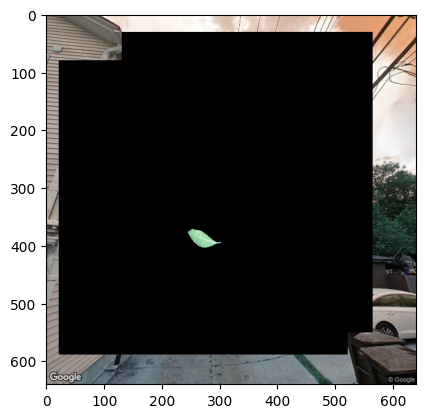

In [53]:
import matplotlib.pyplot as plt
os.makedirs("test/images", exist_ok=True)
os.makedirs("test/labels", exist_ok=True)
process_image(image_files, mask_files, background_files, [5, 10], "test/images", "test/labels", 0)
img = cv2.imread("test/images/synthetic_0.png")
plt.imshow(img)
plt.show()